> ### ResNet

ResNet adds a shortcut to the main path through the network. By stacking these ResNet blocks on top of each other, you can form a very deep network. 

- Easy for one of the blocks to learn an identity function with little risk of harming training set performance.  
- Skip connections helps with vanishing gradients.

Depending mainly on whether the input/output dimensions are same or different, there are two main blocks.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

In [1]:
import h5py
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity

#### Data

<img src="images/signs_data_kiank.png" style="width:450px;height:250px;">

In [8]:
from resnets_utils import *
X_train_orig, y_train_orig, X_test_orig, y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
y_train = convert_to_one_hot(y_train_orig, 6).T
y_test = convert_to_one_hot(y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

#### ResNet50
Paper: [Deep Residual Learning for Image Recognitio](https://arxiv.org/abs/1512.03385)

<img src='https://miro.medium.com/max/1000/1*zbDxCB-0QDAc4oUGVtg3xw.png'></img>

**Identity Block**
- $a^{[l]}$ has the same dimension as $a^{[l+2]}$ 
- $W_s$ is a learned parameter used to resize the input $a^{[l]}$ to match main path. 

**Convolutional Block**
* $a^{[l]}$ has different dimension as $a^{[l+2]}$ 
* The CONV2D layer in the shortcut path is a learned linear function used to resize the input $x$ to a different dimension, to match main path. 

In [45]:
# 适用于ResNet18,34
class BasicBlock(keras.Model):
    expansion=1 #为了和Bottleneck保持一致，方便引用，要写成global变量才能在不用实例化之前直接引用
    def __init__(self, filters, strides, kernel_size=3, downsampling=False, dilation_rate=1): 
        super(BasicBlock, self).__init__()
        #第一层stride有时候需要downsample，而第二层stride默认1
        #tf的padding神奇在于，选择same和stride=2时，相当于减半而非不变
        self.conv1 = layers.Conv2D(filters, kernel_size, strides, padding='same', #由于后面加bn，可以设置use_bias=False，因为会抵消掉
                                  dilation_rate=dilation_rate) #可以增加dilation_rate做空洞卷积
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(filters*BasicBlock.expansion, kernel_size, strides=1, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.relu = layers.Activation('relu') #可以重复使用，因为只是个函数，没有weights
        self.add = layers.Add()
        
        #当downsampling时，需要用ConvBlock，没有relu
        if downsampling:
            self.shortcut = keras.Sequential([
                layers.Conv2D(filters*BasicBlock.expansion, 1, strides),
                layers.BatchNormalization()])
        else:
            self.shortcut = lambda x:x
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x) 
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.add([x, self.shortcut(inputs)])
        x = self.relu(x) 
        return x

In [46]:
inputs = keras.Input(shape=(224,224,3))
model = BasicBlock(64,2,downsampling=True)
model.build(input_shape=(None,224,224,3))
model.call(inputs)
model.summary()

<KerasTensor: shape=(None, 112, 112, 64) dtype=float32 (created by layer 'activation_128')>

Model: "basic_block_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_377 (Conv2D)          (None, 112, 112, 64)      1792      
_________________________________________________________________
batch_normalization_379 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
conv2d_378 (Conv2D)          (None, 112, 112, 64)      36928     
_________________________________________________________________
batch_normalization_380 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_128 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
add_123 (Add)                (None, 112, 112, 64)      0         
_________________________________________________________________
sequential_45 (Sequential)   (None, 112, 112, 64)   

In [47]:
# 适用于ResNet50,101,152
class BottleNeck(keras.Model):
    expansion = 4
    def __init__(self, filters, strides, kernel_size=3, downsampling=False, dilation_rate=1): 
        super(BottleNeck, self).__init__()
        #瓶颈 feature map
        self.conv1 = layers.Conv2D(filters, 1, strides=1, padding='same') #降c
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(filters, kernel_size, strides, padding='same', #降hw
                                   dilation_rate=dilation_rate) #可以增加空洞卷积，对应strides=1
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv2D(filters*BottleNeck.expansion, 1, strides=1, padding='same') #增c
        self.bn3 = layers.BatchNormalization()
        self.relu = layers.Activation('relu')
        self.add = layers.Add()
       
        #当downsampling时，需要用ConvBlock
        if downsampling:
            self.shortcut = keras.Sequential([
                layers.Conv2D(filters*BottleNeck.expansion, 1, strides),
                layers.BatchNormalization()])
        else:
            self.shortcut = lambda x:x
            
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x) 
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x) 
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.add([x, self.shortcut(inputs)])
        x = self.relu(x)
        return x

In [9]:
inputs = keras.Input(shape=(224,224,3))
model = BottleNeck(64,2, downsampling=True)
model.build(input_shape=(None,224,224,3))
model.call(inputs)
model.summary()

<KerasTensor: shape=(None, 112, 112, 256) dtype=float32 (created by layer 'activation_2')>

Model: "bottle_neck_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 64)      256       
_________________________________________________________________
batch_normalization_6 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
batch_normalization_7 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 256)     16640     
_________________________________________________________________
batch_normalization_8 (Batch (None, 112, 112, 256)     1024      
_________________________________________________________________
activation_2 (Activation)    multiple                

<img src="images/resnet_structure.jpg" style="width:600px;height:250px;">

In [23]:
class ResNet(keras.Model):    
    def __init__(self, name, block=None, n_blocks=None, num_classes=10, 
                 dilation_rate=[1,1,1], #若增加空洞卷积，layer 5直接指定每个block的d
                 os=16): #output_stride 可选下采样倍数os=8/16，传统resnet都是2**5=32倍downsampling
        super(ResNet, self).__init__(name=name) 
       
        # 结构：使用自定义的结构，或者经典结构
        self.structure = name
        self.block = block #用basicblock还是bottleneck
        self.n_blocks = n_blocks #每个block循环次数
        self.num_classes = num_classes 
        self.get_structure() #重新整理结构
    
        # Stem 
        self.layer1 = keras.Sequential(
            [layers.ZeroPadding2D(3), #由于Conv2D内无法自定义padding=3，需要先另外做padding 
             layers.Conv2D(64, 7, 2), #2倍downsample
             layers.BatchNormalization(), 
             layers.Activation('relu'), 
             layers.MaxPool2D(3, 2, padding='same')]) #4倍downsample
        
        if os==16 and dilation_rate==[1,1,1]: #代表用传统的32倍downsample，不用空洞卷积
            strides=[1,2,2,2]
        elif os==16: #若16倍downsample，仅最后layer 5 strides=1
            strides=[1,2,2,1] 
        elif os==8: #若8倍downsample，最后layer 4-5 strides=1
            strides=[1,2,1,1] 
            
        #除了layer2因为有事先pooling降维之外，其余layer都是第一个block的stride=2降维，其余blocks的stride=1
        self.layer2 = self.build_blocks(64, self.n_blocks[0], strides=strides[0])         
        self.layer3 = self.build_blocks(128, self.n_blocks[1], strides=strides[1]) #8倍downsample，根据下面layers决定最终downsample倍数   
        self.layer4 = self.build_blocks(256, self.n_blocks[2], strides=strides[2], 
                                        dilation_rate=16//os) #可以对每个block做空洞d，因为不同resnet结构layer4的n_blocks不同，在函数另外构造d列表     
        self.layer5 = self.build_blocks(512, self.n_blocks[3], strides=strides[3], 
                                        #dilation_rate=dilation_rate) #由于layer5统一都是3个blocks，直接指定每个block的空洞d，如[1,2,1]
                                        dilation_rate=[i*16//os for i in dilation_rate]) #若下采样os=8倍为止，那么这层的dilated_rate要乘以2
        
        #如果没有classes，则不返回classifier部分，可以把resnet用作其他模型的backbone结构
        if self.num_classes:
            self.avgpool = layers.GlobalAveragePooling2D()  # 降为1x1xc        
            self.fc = layers.Dense(self.num_classes, activation='softmax') 
    
    
    def get_structure(self):
        versions = {'resnet18':(BasicBlock,[2,2,2,2]), 
                     'resnet34':(BasicBlock,[3,4,6,3]),
                     'resnet50':(BottleNeck,[3,4,6,3]),
                     'resnet101':(BottleNeck,[3,4,23,3]),
                     'resnet152':(BottleNeck,[3,8,36,3])}
        
        if not self.block or not self.n_blocks: #如果任意一项没有定义
            self.block, self.n_blocks = versions[self.structure]
        
        
    def build_blocks(self, filters, n_blocks, strides, dilation_rate=1):
        if isinstance(dilation_rate, int): #根据具体blocks数构造
            dilation_rate=[dilation_rate]*n_blocks
            
        res_blocks = keras.Sequential() 
        res_blocks.add(self.block(filters, strides, downsampling=True, dilation_rate=dilation_rate[0])) 
        for i in range(1, n_blocks): #跳过第一个block            
            res_blocks.add(self.block(filters, strides=1, dilation_rate=dilation_rate[i])) 
        return res_blocks
 

    def call(self, inputs): 
        x = self.layer1(inputs)  
        x = self.layer2(x)         
        x = self.layer3(x)         
        x = self.layer4(x)         
        x = self.layer5(x) 
        
        if self.num_classes: 
            x = self.avgpool(x)          
            x = self.fc(x)     
        return x

In [40]:
inputs = keras.Input(shape=(224,224,3))
model = ResNet('resnet50', num_classes=None, dilation_rate=[1,2,1], os=16)
model.build(input_shape=(None,224,224,3))
model.call(inputs)
model.summary()

<KerasTensor: shape=(None, 14, 14, 2048) dtype=float32 (created by layer 'sequential_43')>

Model: "resnet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_36 (Sequential)   (None, 56, 56, 64)        9728      
_________________________________________________________________
sequential_37 (Sequential)   (None, 56, 56, 256)       220032    
_________________________________________________________________
sequential_39 (Sequential)   (None, 28, 28, 512)       1230336   
_________________________________________________________________
sequential_41 (Sequential)   (None, 14, 14, 1024)      7129088   
_________________________________________________________________
sequential_43 (Sequential)   (None, 14, 14, 2048)      14998528  
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [19]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
history = model.fit(X_train, Y_train, epochs = 3, batch_size = 32, validation_data = (X_test, y_test))

Epoch 1/3
34/34 [==============================] - 123s 4s/step - loss: 0.3194 - accuracy: 0.9000
Epoch 2/3
34/34 [==============================] - 118s 3s/step - loss: 0.2371 - accuracy: 0.9269
Epoch 3/3
34/34 [==============================] - 143s 4s/step - loss: 0.2737 - accuracy: 0.9120


4/4 [==============================] - 4s 479ms/step - loss: 0.6055 - accuracy: 0.8250
Loss = 0.6055490970611572
Test Accuracy = 0.824999988079071


#### ResNeXt-50
Paper: [Aggregated Residual Transformations for Deep Neural Networks](https://arxiv.org/abs/1611.05431)

<img src='https://miro.medium.com/max/1000/1*HelCJiQZEuwuKakRwDdGPw.png'></img>

#### Pretrained

In [49]:
from tensorflow.keras.applications import ResNet50, ResNet50V2, ResNet101, ResNet152 #都有version2

In [50]:
model = ResNet50(input_shape = (224,224,3), include_top=True, 
              weights=None, classes=1000)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

#### Prediction

Input image shape: (1, 64, 64, 3)


Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)]:
[[3.4187831e-06 2.7741338e-04 9.9952292e-01 1.9884338e-07 1.9561945e-04
  4.1168707e-07]]
Class: 2


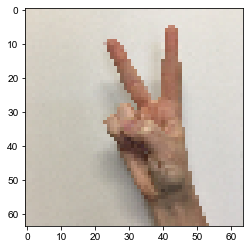

In [28]:
img_path = 'images/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
print('Input image shape:', x.shape)
plt.imshow(img)
prediction = model.predict(x)
print(f"Class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)]:\n{prediction}")
print("Class:", np.argmax(prediction))